In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(10.0, 10.0/golden))

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

# PULIZIA DATI
distance_cond = tragitti[distance_param] != 0
moovit_cond = tragitti['Public'] > 12
public_cond = tragitti['Public'] != 0
bike_cond = tragitti['Bike'] != 0
foot_cond = tragitti['Foot'] != 0
car_cond = tragitti['Car'] != 0
car2go_cond = tragitti['Car2Go'] != 0
enjoy_cond = tragitti['Enjoy'] != 0
coherence_cond = (tragitti['Car'] <= tragitti['Car2Go']) & (tragitti['Car'] <= tragitti['Enjoy'])
cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond

In [2]:
# Velocita' media durante il giorno
def tmedio_macchina_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = tragitti_fascia_oraria[mezzo] - tragitti_fascia_oraria['Car']
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def tmedio_macchina_week(df, mezzo):
    short_paths = df[distance_param].between(2.0, 4.0)
    medium_paths = df[distance_param].between(4.0, 6.0)
    long_paths = df[distance_param].between(6.0, 10.0)
    
    lst = [
        tmedio_macchina_giorno(df[short_paths], mezzo),
        tmedio_macchina_giorno(df[medium_paths], mezzo),
        tmedio_macchina_giorno(df[long_paths], mezzo)]
    
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=['[2, 4) km', '[4, 6) km', '[6, 10) km']).round(2)

wcolors = ['blue', 'green', 'purple']

In [3]:
tragitti.head()

,Lat,Lon,Elat,Elon,ADistance,FDistance,Year,Month,Day,Hour,...,Public,Public2,Bike,Foot,Car,Car2Go,Enjoy,Car2GoFreeCars,EnjoyFreeCars,CDistance
64800,45.474498,9.180897,45.496506,9.224699,4.200852,5.1607,2020,5,4,0,...,33,0,25,69,12,16,17,936,645,6.1379
64801,45.443876,9.184415,45.484429,9.187623,4.516006,5.1087,2020,5,4,0,...,28,0,27,68,14,20,20,936,645,7.2949
64802,45.450619,9.182201,45.502500,9.181618,5.768806,6.3926,2020,5,4,0,...,37,0,36,86,18,22,19,936,645,8.8463
64803,45.504757,9.188484,45.468675,9.156064,4.741568,5.7370,2020,5,4,0,...,48,0,26,77,14,18,23,936,645,6.9053
64804,45.480547,9.195806,45.501923,9.203171,2.445134,2.9488,2020,5,4,0,...,35,0,16,39,9,10,21,936,640,3.4690


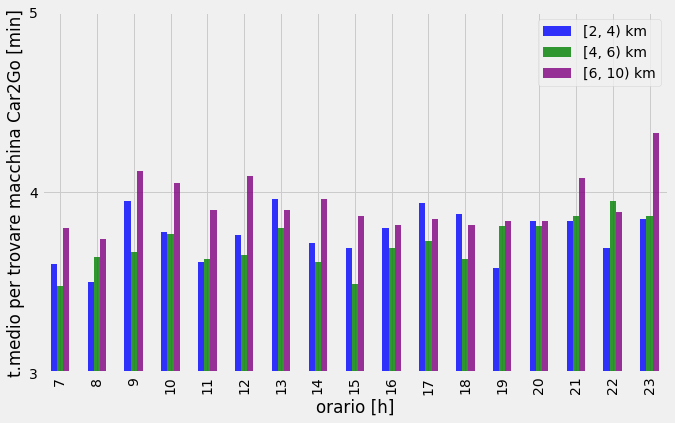

In [4]:
tmedio_macchina_week(tragitti[car_cond], 'Car2Go').plot.bar(color=wcolors, alpha=.8)
plt.ylim(3, 5)
plt.yticks(range(3, 6, 1))
plt.xlabel('orario [h]')
plt.ylabel('t.medio per trovare macchina Car2Go [min]')
plt.show()

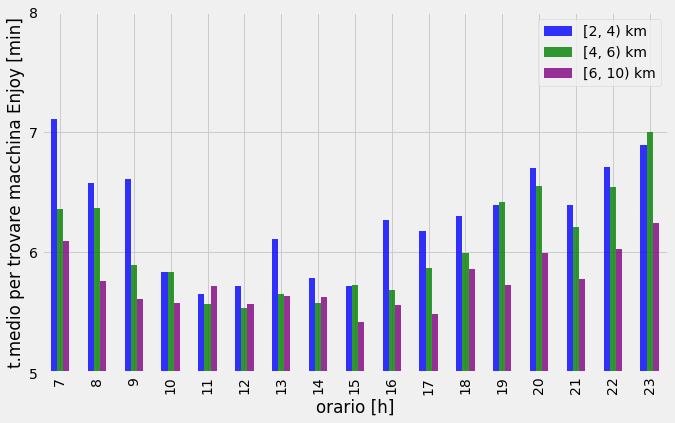

In [5]:
tmedio_macchina_week(tragitti[car_cond], 'Enjoy').plot.bar(color=wcolors, alpha=.8)
plt.ylim(5, 8)
plt.yticks(range(5, 9, 1))
plt.xlabel('orario [h]')
plt.ylabel('t.medio per trovare macchina Enjoy [min]')
plt.show()

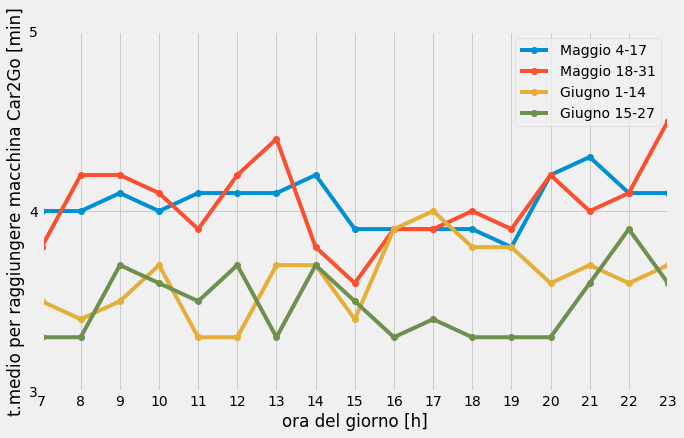

In [6]:
lst = [
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17) & car_cond], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31) & car_cond], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14) & car_cond], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27) & car_cond], 'Car2Go')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot(marker='o')
plt.ylim(3, 5)
plt.yticks(range(3, 6, 1))
plt.xticks(range(7, 24, 1))
plt.xlabel('ora del giorno [h]')
plt.ylabel('t.medio per raggiungere macchina Car2Go [min]')
plt.show()

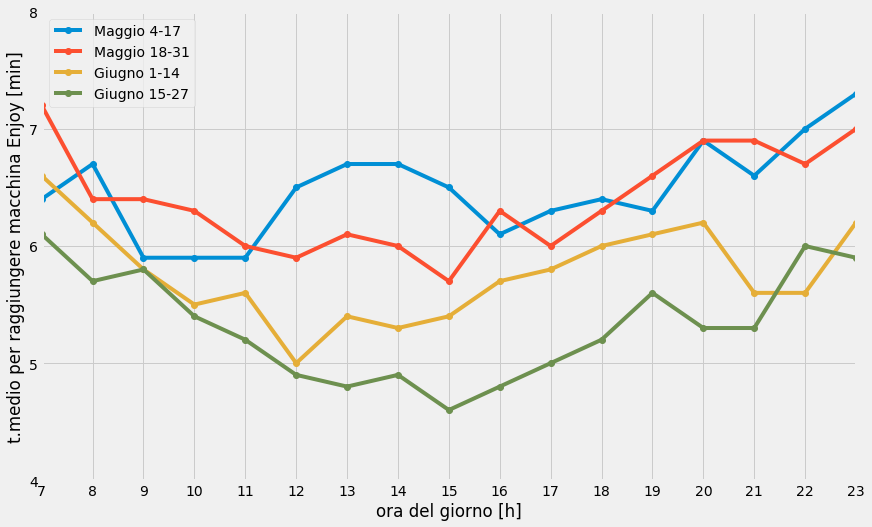

In [7]:
lst = [
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17) & car_cond], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31) & car_cond], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14) & car_cond], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27) & car_cond], 'Enjoy')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

plt.rc('figure', figsize=(13.0, 13.0 / golden))
confronto_vmedie_week_by_week.plot(marker='o')
plt.ylim(4, 8)
plt.yticks(range(4, 9, 1))
plt.xticks(range(7, 24, 1))
plt.xlabel('ora del giorno [h]')
plt.ylabel('t.medio per raggiungere macchina Enjoy [min]')
plt.show()

In [8]:
def tmedio_week_weekend(df, mezzo):
    sd = 4
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd, sd + 4)) |
            (df['Day'].between(sd + 7, sd + 7 + 4)) |
            (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
            (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 1 + 4)) |
            (df['Day'].between(1 + 7, 1 + 7 + 4)) |
            (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
            (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd + 5, sd + 5 + 1)) |
            (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
            (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
            (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1 + 5, 1 + 5 + 1)) |
            (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
            (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
            (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))
        
    lst = [
        tmedio_macchina_giorno(df[weeks], mezzo),
        tmedio_macchina_giorno(df[weekends], mezzo)]
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=['Lun-Ven', 'Sab-Dom']).round(2)

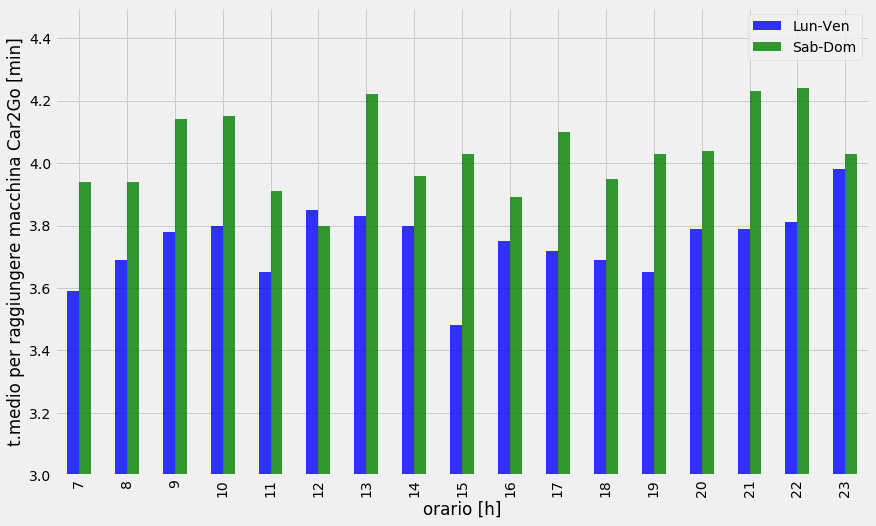

In [9]:
tmedio_week_weekend(tragitti[car_cond], 'Car2Go').plot.bar(color=wcolors, alpha=.8)
plt.ylim(3, 4.5)
plt.xlabel('orario [h]')
plt.ylabel('t.medio per raggiungere macchina Car2Go [min]')
plt.show()

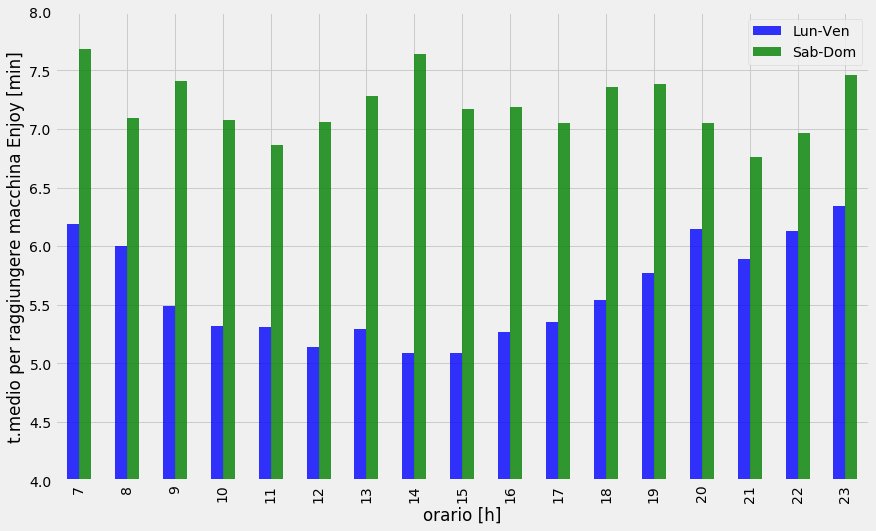

In [10]:
tmedio_week_weekend(tragitti[car_cond], 'Enjoy').plot.bar(color=wcolors, alpha=.8)
plt.ylim(4, 8)
plt.xlabel('orario [h]')
plt.ylabel('t.medio per raggiungere macchina Enjoy [min]')
plt.show()

In [11]:
df = tragitti
sd = 4
weeks = \
    ((df['Month'] == 5) & (
        (df['Day'].between(sd, sd + 4)) |
        (df['Day'].between(sd + 7, sd + 7 + 4)) |
        (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
        (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
    ((df['Month'] == 6) & (
        (df['Day'].between(1, 1 + 4)) |
        (df['Day'].between(1 + 7, 1 + 7 + 4)) |
        (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
        (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

weekends = \
    ((df['Month'] == 5) & (
        (df['Day'].between(sd + 5, sd + 5 + 1)) |
        (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
        (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
        (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
    ((df['Month'] == 6) & (
        (df['Day'].between(1 + 5, 1 + 5 + 1)) |
        (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
        (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
        (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))

df[weeks][['Month', 'Day']].drop_duplicates()

,Month,Day
64800,5,4
65880,5,5
66960,5,6
68040,5,7
69120,5,8
72350,5,11
73430,5,12
74510,5,13
75590,5,14
76670,5,15


In [12]:
df[weekends][['Month', 'Day']].drop_duplicates()

,Month,Day
70200,5,9
71290,5,10
77750,5,16
78830,5,17
85300,5,23
86380,5,24
92840,5,30
93920,5,31
100410,6,6
101490,6,7
